In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import librosa
import scipy.ndimage
from IPython.display import display, Audio

In [12]:
from itertools import count
from typing import Any, Callable, Tuple, Optional


def beta_divergence(x: np.ndarray, y: np.ndarray, beta: float):
    """returns beta divergence

    Args:
        a (np.ndarray): first matrix
        b (np.ndarray): second matrix
        beta (float): beta parameter
    """

    if beta == 0:
        ret = x / y - np.log(x / y) - 1
    elif beta == 1:
        ret = x * (np.log(x) - np.log(y)) + (y - x)
    else:
        ret = (
            (
                np.power(x, beta)
                + (beta - 1) * np.power(y, beta)
                - beta * x * np.power(y, beta - 1)
            )
            / beta
            / (beta - 1)
        )
    return np.sum(ret)


def linear_warmup(epoch, epoch0, value0, epoch1, value1):
    if epoch < epoch0:
        return value0
    elif epoch > epoch1:
        return value1
    return (epoch - epoch0) * (value1 - value0) / (epoch1 - epoch0)


def gen_kernel(c: int):
    kern = np.zeros((2 * c, 2 * c))
    kern[c:, c:] = 1
    kern[:c, :c] = 1
    # kern = scipy.ndimage.gaussian_filter(kern,5)
    return kern


def nmf(
    V: np.ndarray,
    W_init: np.ndarray,
    H_init: np.ndarray,
    beta: float = 2,
    n_epochs: int = 50,
    polyphony_limit: Optional[int] = None,
    continuous_len: Optional[int] = None,
    warmup: Tuple[int, float, int, float] = (10, 0, 20, 1),
):
    assert not np.isnan(W_init).any(), "W_init contains NaN"
    assert not np.isnan(H_init).any(), "H_init contains NaN"
    assert np.all(W_init > 0), "W_init is not positive"
    assert np.all(H_init > 0), "H_init is not positive"
    eps = 1e-20
    losses = []
    regulation_strengths = []
    Hs = []
    H_s = []

    W = W_init.copy()
    H = H_init.copy()

    if continuous_len is not None:
        kernel = gen_kernel(continuous_len)
        # kernel = np.eye(2*continuous_len)
    pbar = tqdm(total=n_epochs)

    for i in range(n_epochs):
        dH = (W.T @ np.multiply(V, np.power(W @ H, beta - 2))) / (
            W.T @ np.power(W @ H, beta - 1) + eps
        )
        assert not np.isnan(dH).any(), f"NaN in dH at iter {i}"
        H *= dH
        # dW = (np.multiply(V, np.power(W @ H, beta - 2)) @ H.T) / (
        #     np.power(W @ H, beta - 1) @ H.T + eps
        # )
        # assert not np.isnan(dW).any(), f"NaN in dW at iter {i}"
        # W *= dW

        # regulation_strength = 1 - np.exp(-warmup_factor * i)
        regulation_strength = linear_warmup(i, *warmup)
        regulation_strengths.append(regulation_strength)

        H_ = H.copy()

        # 3.2 Restricting the number of simultaneous activations
        if polyphony_limit is not None:
            colCutoff = -np.partition(-H_, polyphony_limit, 0)[polyphony_limit, :]
            H_[H_ < colCutoff[None, :]] = 0

        # 3.3 Supporting time-continuous activations
        if continuous_len is not None:
            H_ = H_ * scipy.signal.convolve2d(H_, kernel, mode="same")

        H = (1 - regulation_strength) * H + regulation_strength * H_

        H = np.clip(H, 0, 1)

        Hs.append(H)
        H_s.append(H_)

        # Calculate the loss
        loss = beta_divergence(V, W @ H, beta)
        assert not np.isnan(loss).any(), f"NaN in loss at iter {i}"
        losses.append(loss)

        pbar.update(1)
        pbar.set_description(f"loss={loss:.2f}")
    return Hs, H_s, losses, regulation_strengths

In [43]:
FS = 22050
NFFT = 1024
HLEN = 512

In [44]:
refs = [
    librosa.load(path, sr=FS)[0] for path in ["linear-mix-1.wav", "linear-mix-2.wav"]
]
mix, _ = librosa.load("linear-mix.wav", sr=FS)
print([i.shape for i in refs])

[(175711,), (165375,)]


[(513, 344), (513, 323)]
(513, 667)


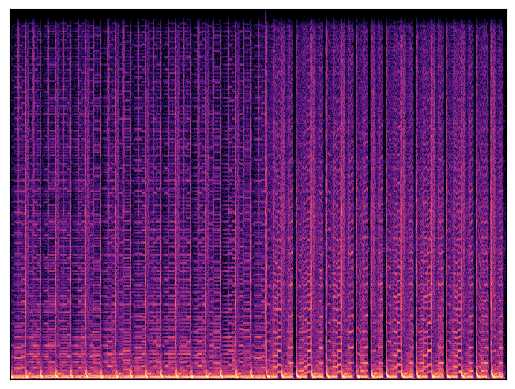

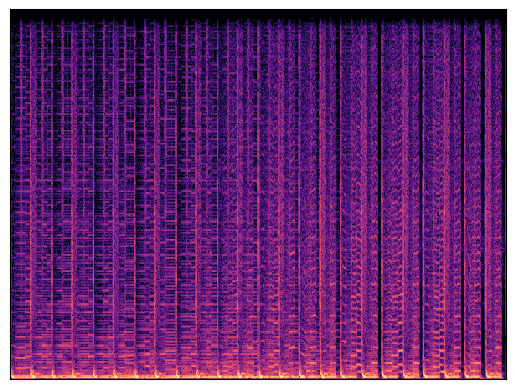

(513, 667)
7.223352e-11 1.0
(513, 485)
1.0326151e-10 1.0


In [45]:
Ws = [np.abs(librosa.stft(ref, n_fft=NFFT, hop_length=HLEN)) for ref in refs]
print([i.shape for i in Ws])
W = np.concatenate(Ws, axis=1)
print(W.shape)
V = np.abs(librosa.stft(mix, n_fft=NFFT, hop_length=HLEN))
# W = librosa.feature.melspectrogram(y=ref, sr=FS, n_fft=NFFT, hop_length=HLEN)
# V = librosa.feature.melspectrogram(y=mix, sr=FS, n_fft=NFFT, hop_length=HLEN)

W /= W.max()
V /= V.max()

W[W == 0] = 1e-50
V[V == 0] = 1e-50

librosa.display.specshow(librosa.amplitude_to_db(W))
plt.show()
librosa.display.specshow(librosa.amplitude_to_db(V))
plt.show()
print(W.shape)
print(W.min(), W.max())
print(V.shape)
print(V.min(), V.max())

In [46]:
H_init = np.random.rand(W.shape[1], V.shape[1])
# H_init = np.zeros((W.shape[1], V.shape[1])) + 1e-30
Hs, H_s, losses, regulation_strengths = nmf(
    V,
    W_init=W,
    H_init=H_init,
    beta=0.5,
    n_epochs=100,
    warmup=(10, 0, 100, 1),
    polyphony_limit=None,
    continuous_len=None,
)

  0%|          | 0/100 [00:00<?, ?it/s]

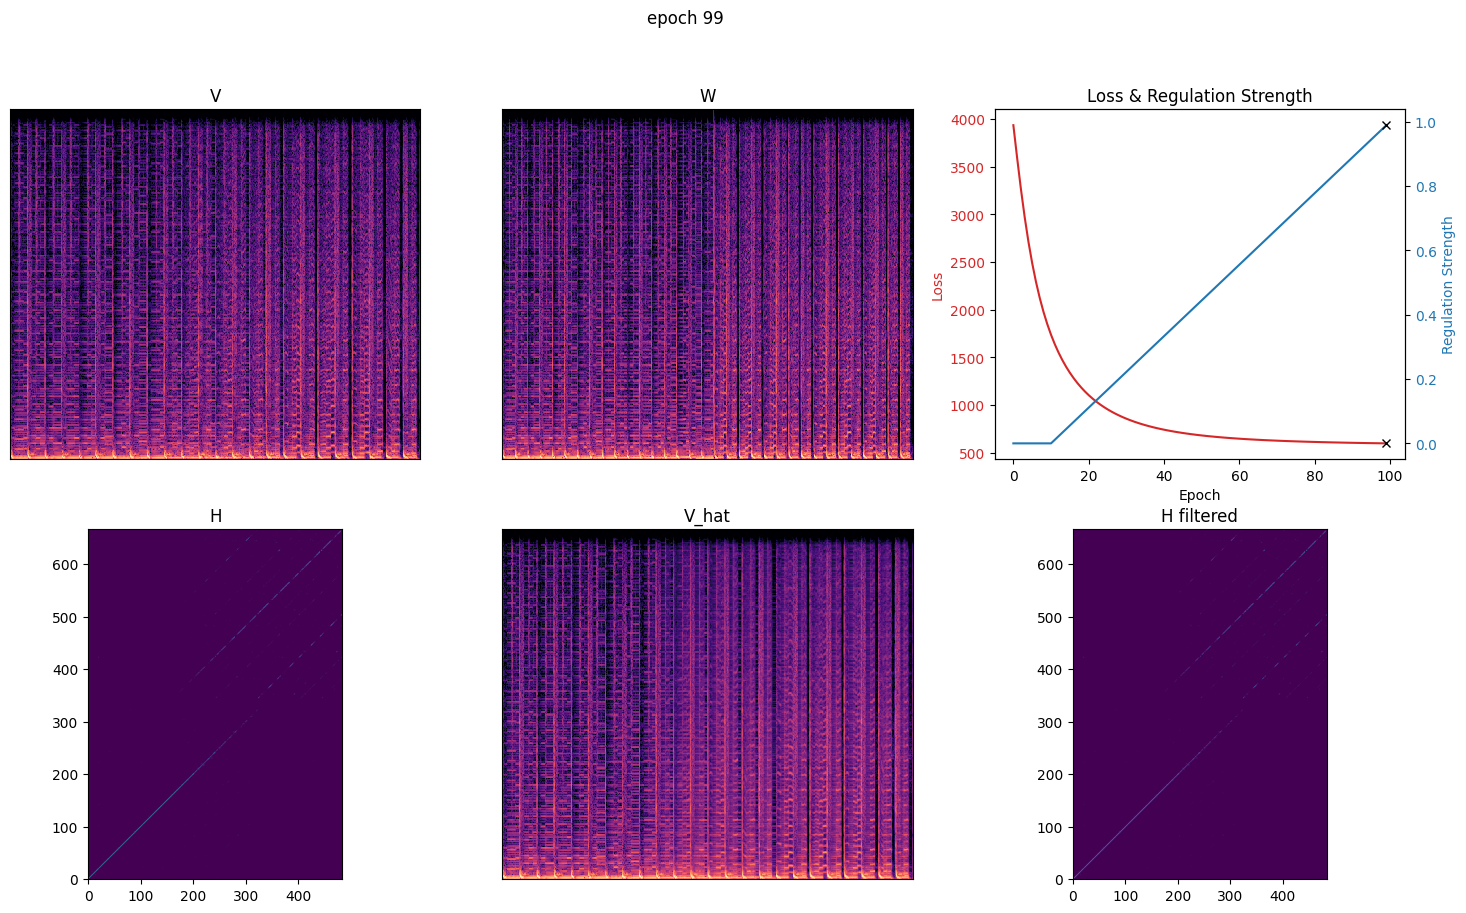

In [47]:
import ipywidgets
from IPython.display import display


def update_plot(epoch):
    dilate = 30
    plt.figure(figsize=(18, 10))
    plt.suptitle(f"epoch {epoch}")

    plt.subplot(2, 3, 1)
    librosa.display.specshow(librosa.amplitude_to_db(V))
    plt.title("V")

    plt.subplot(2, 3, 2)
    librosa.display.specshow(librosa.amplitude_to_db(W))
    plt.title("W")

    ax1 = plt.subplot(2, 3, 3)

    color = "tab:red"
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color=color)
    ax1.plot(losses, color=color)
    ax1.tick_params(axis="y", labelcolor=color)

    ax2 = ax1.twinx()
    color = "tab:blue"
    ax2.set_ylabel("Regulation Strength", color=color)
    ax2.plot(regulation_strengths, color=color)
    ax2.tick_params(axis="y", labelcolor=color)

    ax1.plot(epoch, losses[epoch], "x", color="black")
    ax2.plot(epoch, regulation_strengths[epoch], "x", color="black")

    plt.title("Loss & Regulation Strength")

    plt.subplot(2, 3, 4)
    # activation = scipy.ndimage.grey_dilation(Hs[epoch], (dilate, dilate))
    activation = Hs[epoch]
    plt.imshow(activation, origin="lower")
    plt.title("H")

    plt.subplot(2, 3, 5)
    librosa.display.specshow(librosa.amplitude_to_db(W @ Hs[epoch]))
    plt.title("V_hat")

    plt.subplot(2, 3, 6)
    plt.imshow(H_s[epoch], origin="lower")
    plt.title("H filtered")
    plt.show()


update_plot(len(Hs) - 1)

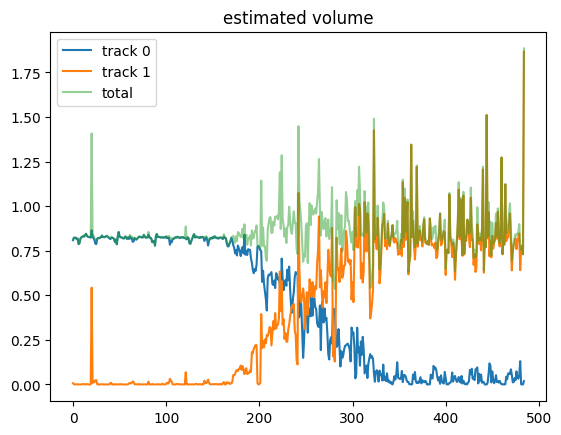

In [48]:
acc = 0
for i in range(len(Ws)):
    plt.plot(Hs[-1][acc : acc + Ws[i].shape[1], :].sum(axis=0), label=f"track {i}")
    acc += Ws[i].shape[1]
plt.plot(Hs[-1].sum(axis=0), label="total", alpha=0.5)
plt.legend()
plt.title("estimated volume")
plt.show()

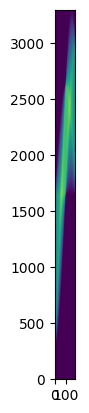

In [139]:
import skimage


hough, _, _ = skimage.transform.hough_line(Hs[-1])
plt.imshow(hough, origin="lower")